In [47]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [48]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [49]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, MetaData


In [50]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [51]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [52]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [53]:
# Save references to each table
measurement = Base.classes.measurement
Station = Base.classes.station

In [54]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [55]:
# Find the most recent date in the data set.
inspector = inspect(engine)
inspector.get_table_names()

session.query(measurement.date).order_by(measurement.date.desc()).first() 

('2017-08-23',)

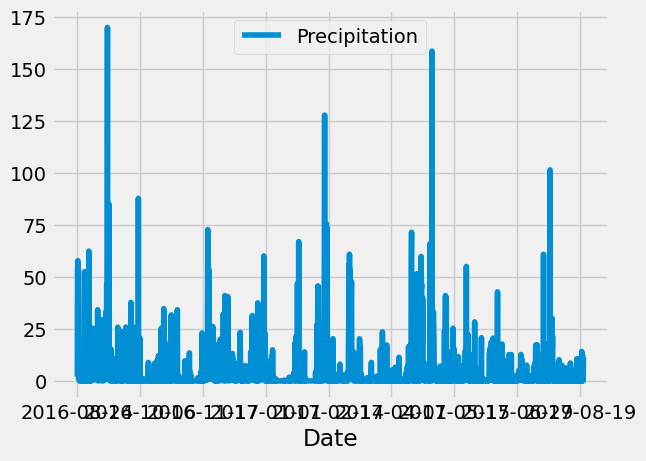

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
# Calculate the date one year from the last date in data set.
latest_year = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= latest_year).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df = precipitation_df.dropna()

# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot().get_figure()
ax.savefig("Resources/Precipitation_last_12months.png")

In [59]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [61]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station)
print(total_stations.count())

9


In [63]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_descending = session.query(measurement.station, func.count(measurement.station)).\
        group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations_descending

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [84]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_id = "USC00519281"  

temperature_frequencies = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == active_station_id).all()

print(temperature_frequencies)

[(12.2, 29.4, 22.03582251082252)]


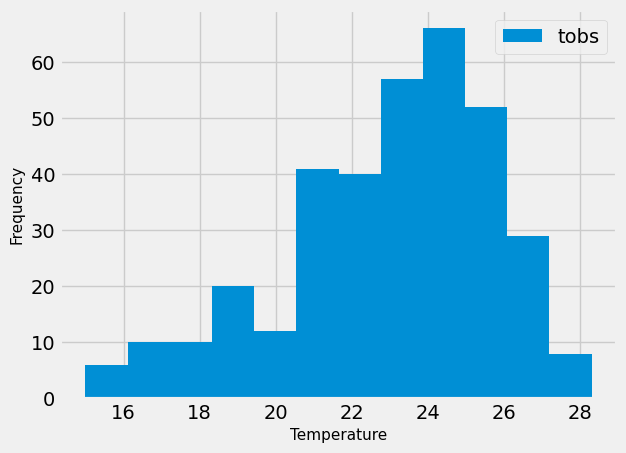

In [88]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = active_stations_descending[0][0] if active_stations_descending else None

temp_results = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= latest_year).\
    group_by(measurement.date).all()

temp_results_df = pd.DataFrame(data=temp_results, columns=["date", "tobs"])
temp_results_df = temp_results_df.set_index('date', drop=True)

plt.hist(temp_results_df['tobs'], 12, label="tobs")
plt.ylabel("Frequency", fontsize=11)
plt.xlabel("Temperature", fontsize=11)
plt.legend()
plt.savefig("Resources/Temperature_for_active station_last_12months.png")
plt.show()


# Close Session

In [89]:
# Close Session
session.close()